### Eluvio Data Challenge 

__Data__: News headlines dataset from 2008-01-25 to 2016-11-22, including time created, upvotes, authors, over_18 (Whether or not the thread has been marked as NSFW).  

__What I want to learn from the data__:
- Statistics on the posts, number of posts with time, active authors, most mentioned countries, etc. 
- Topic modeling, e.g., economy, politics, international, domestic.  
- A simple model to predict the number of upvotes based on the time and title content information.   


__What I did in the notebook__:
-  __1) Data Cleaning:__
No missing data (good); One outlier (very high upvotes); Sort the data frame based on TimeStamp (maybe redundant in this case). 
- __2) Feature Engineer:__
Timestamp: week of the day (0 is Monday and 6 is Sunday); hours of the day; weekend or weekday; countries and cities mentioned in the title.  
 
- __3) Visualization:__ 
Number of post vs time; most active/popular authors; best time to post news etc. 
Word and title embedding using word2vec. 

- __4) Clustering:__
Applied K-means clustering and LDA for topic modeling.  

- __5) Forecasting:__
Regression models: linear regression, lasso regression as the baseline models. __Evaluation Metrics__: Regression: MSE MAE(less sensitive to outliers) on the validation set.


### 1. Load Data and Packges

In [39]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set()
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
%matplotlib inline
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from contextlib import contextmanager
import time
from geotext import GeoText
import re
from collections import Counter

In [38]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')

In [3]:
df.info()
df.head() # no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
time_created    509236 non-null int64
date_created    509236 non-null object
up_votes        509236 non-null int64
down_votes      509236 non-null int64
title           509236 non-null object
over_18         509236 non-null bool
author          509236 non-null object
category        509236 non-null object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


False    508916
True        320
Name: over_18, dtype: int64


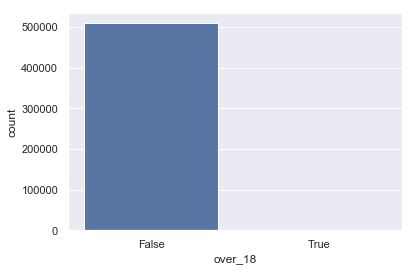

In [4]:
sns.countplot(df['over_18'])
print(df['over_18'].value_counts())

In [5]:
print(df['category'].value_counts())
print(df['down_votes'].value_counts()) # all down_votes are zero 

worldnews    509236
Name: category, dtype: int64
0    509236
Name: down_votes, dtype: int64


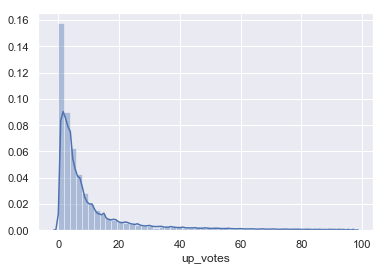

In [6]:
#df[df['total_votes']>df['total_votes'].quantile(0.99)]
sns.distplot(df[df['up_votes']<=97]['up_votes'])

Up_votes follow zero-inflated distributions. Category is uniform, all worldnews. No down_votes. 
18.4% of news have no upvotes. 

### 2. Feature Exploration
In total, 10 more features are generated in the dataset, e.g., the year, month, day extracted from the time_created column, the length of the title, and the country, city name in the titles.

Check the missing features. No. 
Features visualization.

__Fig1.__ Countplots of the number of posts vs year and day of the week.   
__Fig2.__ Barplots of avg upvotes vs year and day of the week.  
__Fig3.__ Total upvotes and mean upvotes vs day time.  
__Fig4.__ Top 30 most active authors and top 30 authors with most upvotes.  
__Fig5.__ Distribution of the length of the news title. Avg votes vs length of news titles.   
__Fig6.__ Top 30 countries in the news with different years. 

In [49]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
def countries(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = ''
    if not count and not city:
        return np.nan
    else:
        for country in count:
            w = w+' '+country
        for c in city:
            w = w+' '+c
        return w

def places(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = 0
    if not count and not city:
        return 0
    else:
        w=len(count)+len(city)
        return w 

def df_feature_engineer(df):
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['day_of_week']=df['date_created'].dt.day_name()
    df['day_of_week_num']=df['date_created'].dt.dayofweek
    df['year'] = df['date_created'].dt.year
    df['month'] = df['date_created'].dt.month
    df['day'] = df['date_created'].dt.day
    df['weekend'] = np.where(df['date_created'].dt.dayofweek>4, 1, 0)
    df['years_to_now'] = (datetime.today() - df['date_created']).dt.days/365
    # Unix tim starts at 00:00:00 Thursday, 1 January 1970
    df['time_created'] = pd.to_datetime(df['time_created'], unit='s')
    df['day_time']=df['time_created'].dt.hour+df['time_created'].dt.minute/60+df['time_created'].dt.second/3600
    df['author_total_posts'] = df['author'].groupby(df['author']).transform('count')
    df = df.drop(columns=['date_created','down_votes','category'])
    df['title_length'] = df['title'].str.split().apply(len)
    df['over_18'] = df['over_18'].map({False:0,True:1})
    df['countries'] = df['title'].apply(lambda x: countries(x))
    df['places'] = df['title'].apply(lambda x: places(x))
    return df

In [50]:
with timer("Generate New Features and Clean Data"):
    df = df_feature_engineer(df)

Generate New Features and Clean Data - done in 59s


In [51]:
df = df.sort_values(['time_created'], ascending=True)
df.head(1)

,time_created,up_votes,title,over_18,author,day_of_week,day_of_week_num,year,month,day,weekend,years_to_now,day_time,author_total_posts,title_length,countries,places
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,0,polar,Friday,4,2008,1,25,0,11.309589,3.568333,50,5,Pakistan,1


Text(0.5,1,'Num of posts vs Day of Week')

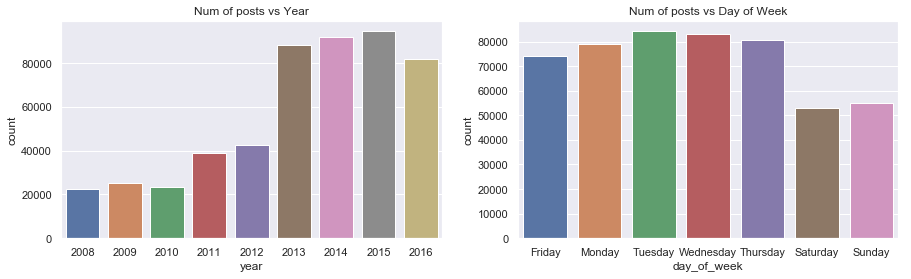

In [10]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g=sns.countplot(x='year',data=df,ax=ax[0])
g.set_title('Num of posts vs Year')
g=sns.countplot(x='day_of_week',data=df,ax=ax[1])
g.set_title('Num of posts vs Day of Week')

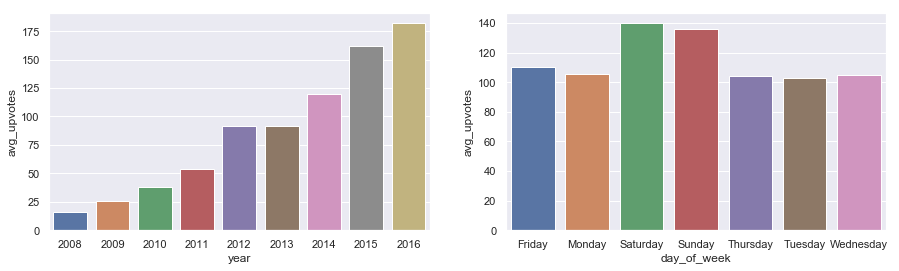

In [11]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
set1 = df.groupby('year').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='year',y='avg_upvotes',data=set1, ax=ax[0])
set2 = df.groupby('day_of_week').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='day_of_week',y='avg_upvotes',data=set2, ax=ax[1])

The number of posts and vistors (users) of the website (if it is a news website) are increasing with time and users become more active. Quite reasonable that news posted on Saturday and Sunday get more upvotes on average. 

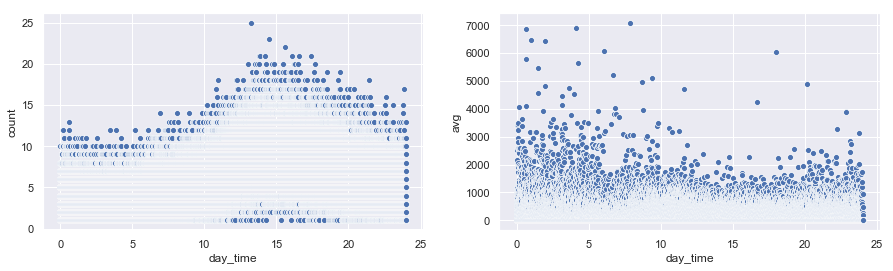

In [12]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
set3 = df.groupby('day_time').count()['up_votes'].reset_index(name='count')
sns.scatterplot(x='day_time', y='count', data=set3, ax=ax[0])
set4 = df.groupby('day_time').mean()['up_votes'].reset_index(name='avg')
sns.scatterplot(x='day_time', y='avg', data=set4, ax=ax[1])

There is one news post get way more upvotes. More posts are at 3 pm in the afternoon. 

In [13]:
df[df['up_votes'] > 20000] # remove it when doing the regression 

,time_created,up_votes,title,over_18,author,day_of_week,day_of_week_num,year,month,day,weekend,years_to_now,day_time,author_total_posts,title_length,countries,places
377200,2015-06-20 16:41:11,21253,A biotech startup has managed to 3-D print fak...,0,KRISHNA53,Saturday,5,2015,6,20,1,3.90411,16.686389,109,49,NaN,0


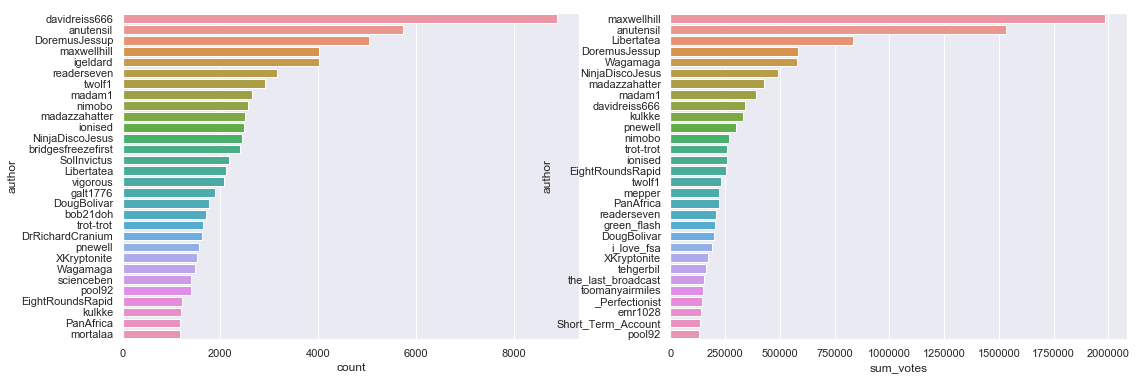

In [14]:
f, ax = plt.subplots(1, 2, figsize=(18, 6))
num = 30
sns.countplot(y=df['author'],\
              order = df['author'].value_counts().iloc[:num].index, ax=ax[0])

set5 = df.groupby('author').sum()['up_votes'].reset_index(name='sum_votes').\
       sort_values(by='sum_votes',ascending=False)
sns.barplot(y='author',x='sum_votes',data=set5.iloc[:num],ax=ax[1])

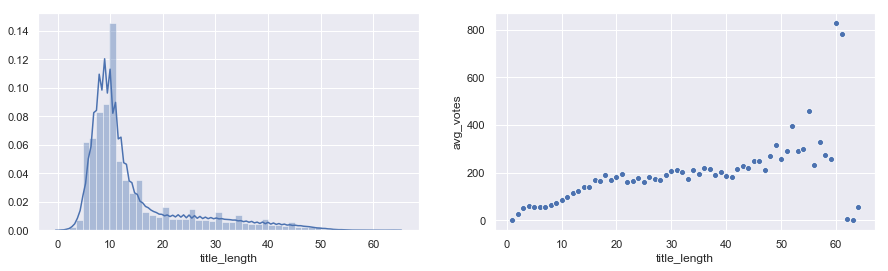

In [15]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(df['title_length'],ax=ax[0])
set6 = df.groupby('title_length').mean()['up_votes'].reset_index(name='avg_votes')
sns.scatterplot(set6['title_length'],set6['avg_votes'],ax=ax[1])

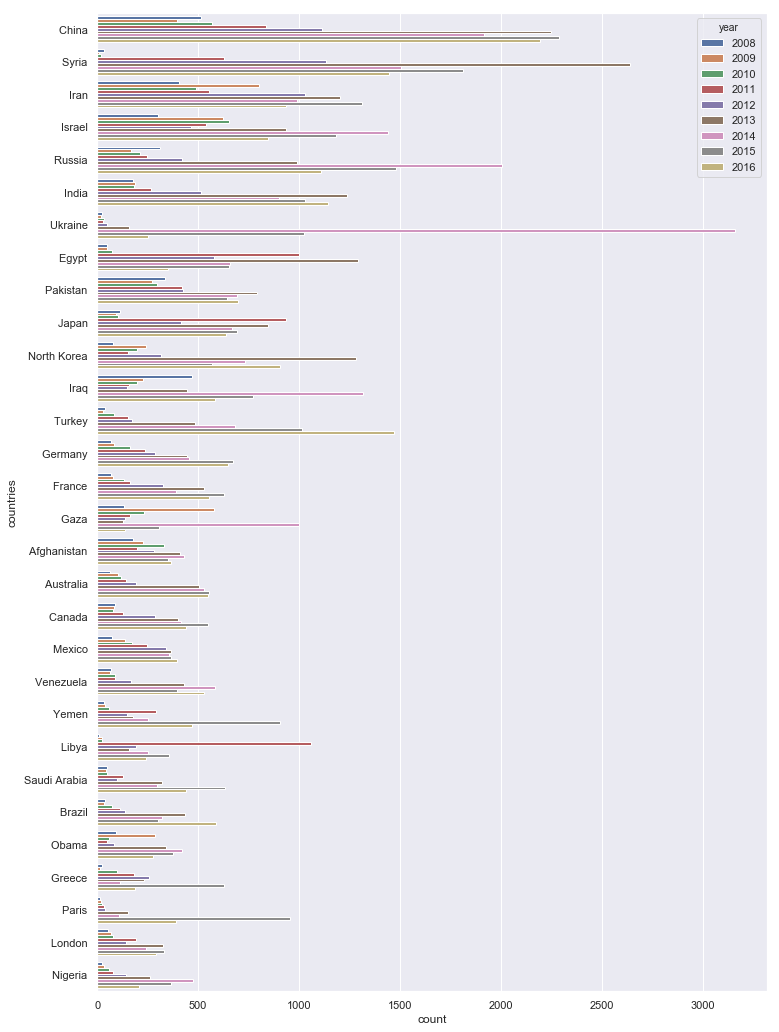

In [16]:
fig = plt.figure(figsize=(12,18))
num = 30
sns.countplot(y=df['countries'],\
              order = df['countries'].value_counts().iloc[:num].index, hue=df['year'])


When the length of titles exceed around 55 words, the avg upvotes start going down. 
The most mentioned countries(cities) are different from year to year, e.g., Ukraine has a lot of news in 
2014 because of 2014 [Ukraine evolution](https://www.bbc.com/news/world-europe-30131108). 

### 3. Text Understanding
- Word cleaning, tokenize, lemmatize,  Word Cloud Visualization. 
Preprocess/clean the text data, using the NLTK package. 
Use word2vec to create word and title embeddings, then visualize them as clusters using t-SNE. 
- Word2vec embedding, (mimic)doc2vec
- Topic Clustering
- Simple regression models: linear and lasso regression

In [17]:
text = df['title']

In [18]:
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud

lemma=WordNetLemmatizer() 
stopwords_en = stopwords.words('english')

def text_process(text):
    # Clean the text
    #text = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"U-turn", "Uturn", text)
    text = re.sub(r"New York Times", "NewYorkTimes", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"U of", "University of", text)
    text = re.sub(r"N Korea", "NorthKorea", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"U S", "US", text)
    text = re.sub(r"U S ", "US", text)
    text = re.sub(r"U N", "UN", text)
    text = re.sub(r"U N ", "UN", text)
    text = re.sub(r"@\S+", "", text)

    word=nltk.word_tokenize(text.lower())
    new_word=[w for w in word if w not in stopwords_en and w.isalpha()]
    new_word=[lemma.lemmatize(w, "v") for w in new_word]
    #new_word=[stemmer.stem(w) for w in new_word]
    return new_word

def word_freq(s):
    txt = s.str.lower().str.cat(sep=' ')  
    words = text_process(txt)
    words_dist = nltk.FreqDist(w for w in words) 
    return words_dist

def plot_cloud(words_dist,size):
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black').generate_from_frequencies(words_dist)
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
print('Let\'s look at an example before and after tokenization and normalization')
print('='*50)
print(text[381])
print('cleaned text')
print('='*50)
print(text_process(text[381]))

Let's look at an example before and after tokenization and normalization
 Iran Defiant Ahead of U.N. Nuclear Watchdog Report
cleaned text
['iran', 'defiant', 'ahead', 'un', 'nuclear', 'watchdog', 'report']


In [20]:
for year in range(2008, 2017):
    words_dist=word_freq(df[df['year']==year]['title'])
    res=[]
    for w, count in words_dist.most_common(10):
        res.append(w)
    print(year, res)

2008 ['us', 'say', 'kill', 'china', 'war', 'world', 'attack', 'iraq', 'iran', 'new']
2009 ['us', 'israel', 'iran', 'say', 'gaza', 'kill', 'world', 'war', 'new', 'israeli']
2010 ['us', 'israel', 'say', 'kill', 'world', 'china', 'new', 'iran', 'war', 'attack']
2011 ['say', 'kill', 'us', 'protest', 'libya', 'egypt', 'new', 'china', 'government', 'force']
2012 ['say', 'kill', 'us', 'china', 'syria', 'iran', 'new', 'news', 'police', 'attack']
2013 ['say', 'us', 'syria', 'kill', 'china', 'new', 'attack', 'world', 'police', 'korea']
2014 ['say', 'us', 'ukraine', 'russia', 'kill', 'new', 'china', 'state', 'attack', 'russian']
2015 ['say', 'us', 'kill', 'china', 'attack', 'new', 'russia', 'state', 'isis', 'syria']
2016 ['say', 'us', 'china', 'kill', 'attack', 'new', 'syria', 'russia', 'state', 'police']


In [21]:
words_dist=word_freq(df['title'])

In [22]:
len(words_dist)
words_dist

FreqDist({'say': 45166, 'us': 39617, 'kill': 28756, 'china': 25755, 'new': 23329, 'attack': 21586, 'syria': 18784, 'russia': 18112, 'world': 17856, 'police': 16682, ...})

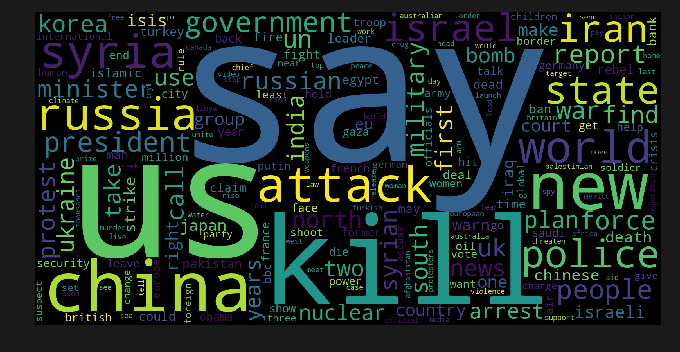

In [23]:
plot_cloud(words_dist,size = (15,5)) 

In [24]:
# news source
words_dist['bbc'] 

5729

__TODO__: extract the sources of news, e.g., BBC/New York Times

### Embedding: Word2Vec  

In [25]:
from gensim.models import KeyedVectors
wv_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True) # 3000000 vocab 

In [26]:
def Word2Vec(wv_model, titles_list):
    big_title_string = ' '.join(titles_list)
    words = text_process(big_title_string)
    # Filter the list of vectors to include only those that Word2Vec has a vector for
    vector_list = [wv_model[word] for word in words if word in wv_model.vocab]
    words_filtered = [word for word in words if word in wv_model.vocab]
    word_vec_zip = zip(words_filtered, vector_list)
    word_vec_dict = dict(word_vec_zip)
    dic = pd.DataFrame.from_dict(word_vec_dict, orient='index')
    print('shape of dictionary',dic.shape)
    return dic

In [27]:
titles_list = [title for title in text]
dic = Word2Vec(wv_model, titles_list)

shape of dictionary (38306, 300)


[__t-Distributed Stochastic Neighbor Embedding (t-SNE)__](https://www.datacamp.com/community/tutorials/introduction-t-sne) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is extensively applied in image processing, NLP, genomic data and speech processing.

In [28]:
from sklearn.manifold import TSNE
from adjustText import adjust_text
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(dic[0:400]) # Use only 400 rows to shorten processing time

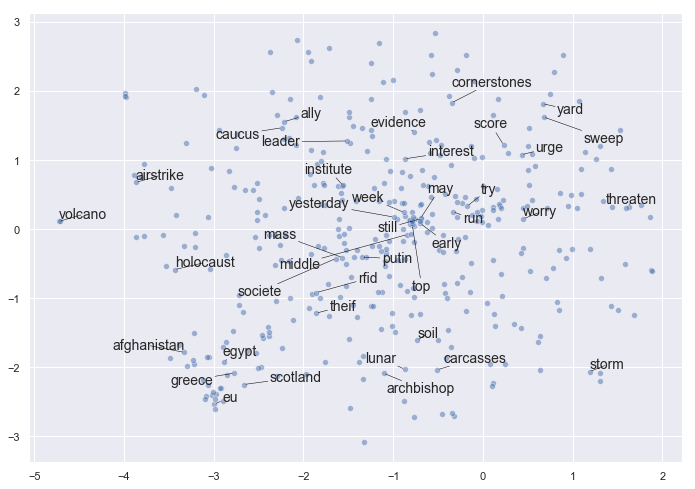

In [29]:
def plot_words(tsne_df, n):
    fig, ax = plt.subplots(figsize = (11.7, 8.27))
    sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

    texts = []
    words_to_plot = list(np.arange(0, 400, n))
    # Append words to list
    for word in words_to_plot:
        texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], dic.index[word], fontsize = 14))
    
    # Plot text using adjust_text (because overlapping text is hard to read)
    adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plot_words(tsne_df, 10)

### Average Words Embedding: (mimic) Doc2Vec
Instead of using Doc2Vec, which would require a lengthy training process, I just average the embeddings of the word vectors in each title.

In [30]:
class Doc2Vec:
    def __init__(self, wv_model, corpus):
        self.word2vec_model = wv_model
        self.corpus = corpus
    # Filter out documents
    def filter_docs(self, texts, condition_on_doc):
        number_of_docs = len(self.corpus)
        texts = [text for (text, doc) in zip(texts, self.corpus)
                 if condition_on_doc(doc)]
        corpus = [doc for doc in self.corpus if condition_on_doc(doc)]
        print("{} docs removed".format(number_of_docs - len(corpus)))
        return (corpus, texts)
    
    def has_vector_representation(self, doc):
        return not all(word not in self.word2vec_model.vocab for word in doc)
    
    def document_vector(self, doc):
        # remove out-of-vocabulary words
        doc = [word for word in doc if word in self.word2vec_model.vocab]
        return np.mean(self.word2vec_model[doc], axis=0)

In [31]:
corpus = df['title'].map(text_process)
temp = Doc2Vec(wv_model, corpus)
corpus, titles_left = temp.filter_docs(titles_list, lambda doc: temp.has_vector_representation(doc))
# Initialize an array for the size of the corpus
x = []
for doc in corpus: 
    x.append(temp.document_vector(doc))
docvec = np.array(x) 

169 docs removed


In [32]:
print(np.shape(docvec))

(509067, 300)


500

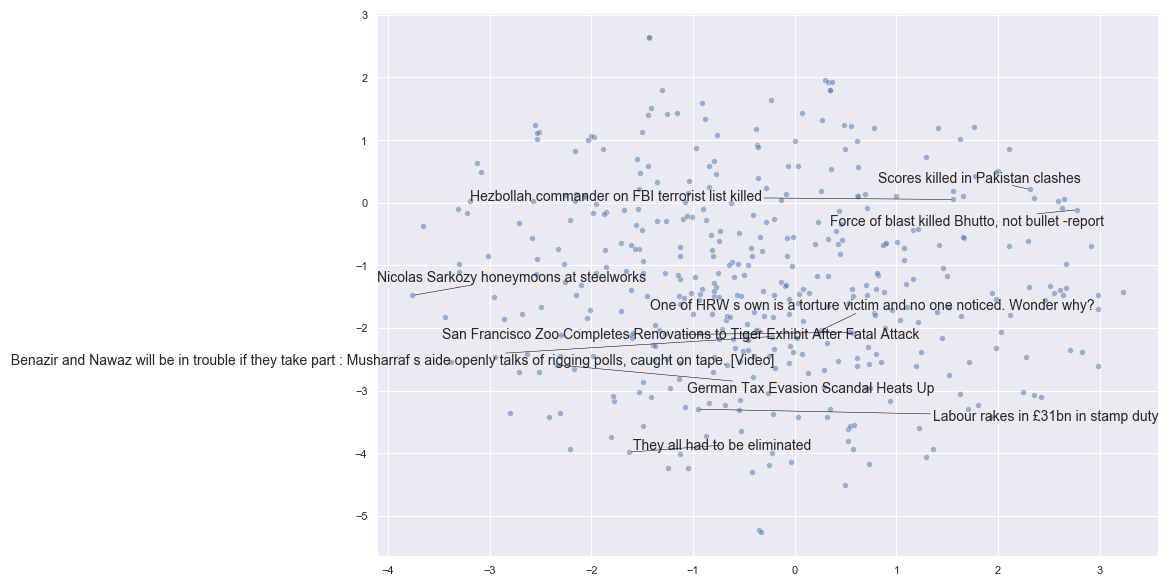

In [33]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(docvec[:400])

fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

### Topic Modeling: LDA and Clustering: K-means
Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. __Latent Dirichlet Allocation (LDA)__ is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 
__K-means__ on the doc2vec space. 

In [34]:
sample = text.sample(frac=0.1) # select only 10% of the data to speed up the process 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(analyzer = text_process)
text_matrix = cv.fit_transform(sample)
#feature_names = cv.get_feature_names()

In [35]:
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words 

In [40]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 8
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)

lda_topic_matrix = lda_model.fit_transform(text_matrix)

lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_n_words_lda = get_top_n_words(10, lda_keys, text_matrix, cv)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  us say president uk ban death million find year china
Topic 2:  say us state news eu ukraine israel russia new world
Topic 3:  japan say government call drug new use french minister back
Topic 4:  us china say iran syria russia north korea nuclear new
Topic 5:  minister india say prime chinese ebola world china new children
Topic 6:  court police protest president say government jail rule uk protesters
Topic 7:  say arrest world new police people find right egypt first
Topic 8:  kill attack say israel syrian israeli people bomb gaza force


In [41]:
df_doc=pd.DataFrame(docvec)
sample_doc = df_doc[0:1000]

from sklearn.cluster import KMeans
num_clusters = 8
km = KMeans(n_clusters=num_clusters, max_iter=100,n_init=60,init='k-means++')
topic_clustered = km.fit_predict(sample_doc)

In [ ]:
''' error = []
for k in range(5,15):
    km = KMeans(n_clusters=k, max_iter=100,n_init=60,init='k-means++')
    topic_clustered = km.fit_predict(sample_doc)
    error.append(km.inertia_)
plt.plot(range(5,15), error) '''

In [42]:
frame = pd.DataFrame(titles_left[0:1000], index = [topic_clustered] , columns = ['title'])
frame.index.value_counts()
frame=frame.reset_index()

In [43]:
for i in range(num_clusters):
    print("Cluster %d:" % i)
    print(frame[frame['level_0']==i]['title'][0:5])

Cluster 0:
54                            Hyperurbanization in China
140    Russia, China challenge US with proposal to ba...
184                Russia, China Challenge US Space Arms
298    Mix-Up Blamed for FDA Failure on China Heparin...
407    China wants online boycott of  decadent, backw...
Name: title, dtype: object
Cluster 1:
14              Sarkozy, Girlfriend Sue Ryanair Over Ad
19                                Rambo banned in Burma
21    Secret CIA flights to Greenland reported; Denm...
30       What the hell is going on in the Eastern Cape?
33               Nicolas Sarkozy and Carla Bruni marry 
Name: title, dtype: object
Cluster 2:
1                      Japan resumes refuelling mission
9     US plans for missile shields in Polish town me...
48    Russia says an Iranian missile test this week ...
60    Volcano Eruption Forces 3000 Ecuadorians Out O...
65    Australia released grisly surveillance picture...
Name: title, dtype: object
Cluster 3:
28    Germany rejects troop re

In [44]:
from sklearn import metrics
coefficient = metrics.silhouette_score(sample_doc, topic_clustered)
print('Silhouette coefficient: {:0.03f}'.format(coefficient))

Silhouette coefficient: 0.023


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

### 4. Regression 
Predict the number of up_votes based on the content of headlines.   
Combined text vectors with other information. 
Baseline Model: linear regression  

In [ ]:
''' from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=10)
# x is the array with our 300-dimensional vectors
reduced_vecs = pca.fit_transform(docvec)
sum(pca.explained_variance_ ) '''

In [52]:
df_concat = df[df['up_votes']<20000] # remove one outlier 

In [53]:
df_concat = df_concat[['title', 'over_18', 'day_of_week_num','year', 'month', 'day', \
      'weekend', 'years_to_now','day_time','author_total_posts','title_length','places','up_votes']]

In [54]:
df_w_vectors = pd.DataFrame(docvec)
df_w_vectors['title'] = titles_left
main = pd.concat((df_w_vectors, df_concat), axis=1)
main.dropna(axis=0, inplace=True)
main.head(1)

,0,1,2,3,4,5,6,7,8,9,...,year,month,day,weekend,years_to_now,day_time,author_total_posts,title_length,places,up_votes
0,-0.045776,0.086182,0.162781,0.033356,-0.012695,0.103027,0.002197,-0.133911,-0.05481,0.18335,...,2008.0,1.0,25.0,0.0,11.309589,3.568333,50.0,5.0,1.0,3.0


In [55]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def model_diagnostics(model, pr=True):
    y_predicted = model.predict(X_val)
    r2 = r2_score(y_val, y_predicted)
    mse = mean_squared_error(y_val, y_predicted)
    mae = mean_absolute_error(y_val, y_predicted)
    if pr:
        print(f"R-Sq: {r2:.4}")
        print(f"RMSE: {np.sqrt(mse)}")
        print(f"MAE: {mae}")

In [56]:
X=main.drop(columns=['up_votes','title'])
y=main['up_votes']

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.1,random_state=101)

In [59]:
reg = LinearRegression().fit(X_train, y_train)
model_diagnostics(reg)

R-Sq: 0.01645
RMSE: 546.3212527711775
MAE: 188.89255677142327


In [60]:
lasso = LassoCV(cv=10).fit(X_train, y_train)
model_diagnostics(lasso)

R-Sq: 0.01658
RMSE: 546.2847446392902
MAE: 187.50645613707837


Not a very strong regression model, might need to think deep on that and maybe try tree regressor. 

__Conclusions__:   
This was a quick try at creating models to do NLP analysis. There are several thoughts, caveats and to-do discussed here.
I looked at the distributions of the number of news with time. The online news and upvotes are increasing with time, which means people are getting used to the electric way of reading news.
Using the bow model, here list the top 10 words from 2008 to 2016. A lot of terror attacks happened in these 8 years.
Using the word2vec embedding, the averaged doc vectors are mapped for headline clustering.
I also tried the linear regression model to predict the sum of upvotes based on the content and other information.

__Todo__:
How to check miss spelling words or abbreviation.
Capitalized letter matters. For example, the US and us.
N-gram word recognition, e.g., New York Times, North Korean.
Sentiment analysis of the title (positive, negative or neutral using textblob package).
News sources can also be extracted, e.g., BBC. Some analysis of the popularity of various news channels can be compared.
LSTM models on regression.

__References__:
[predicting reddit upvote](https://towardsdatascience.com/predicting-reddit-comment-karma-a8f570b544fc)
[topic modeling](https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda)
[different embedding](https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings)
[LDA](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)


In [ ]:
'''from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

X_train, X_test, y_train, y_test = train_test_split(X['title'], y,test_size=0.1,random_state=101)
## some config values 
embed_size = 300 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 20 # max number of words in a question to use


## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
train_X = tokenizer.texts_to_sequences(X_train)
test_X = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in wv_model:
        embedding_vector = wv_model.get_vector(word)
        embedding_matrix[i] = embedding_vector

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model.summary())

model.fit(train_X, y_train.values, batch_size=512, epochs=1, validation_data=(test_X, y_test.values)) '''